In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing zeolite synthesis descriptors

In [ ]:
import copy
import os
from warnings import simplefilter

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from analysis_functions import (
    my_mpl_settings,
    parse_sisso_eqn,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

In [3]:
# Pandas complains about performance warnings when adding too many columns
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# some runtime warnings are expected and can be ignored when evaluating SISSO expressions
simplefilter(action="ignore", category=RuntimeWarning)

In [4]:
my_mpl_settings()

TODOs:

- [ ] remove any extraneous code that was not part of the analysis for the manuscript
- [ ] update variable names throughout so the notebook runs smoothly (though make sure you don't delet any data!!)
- [ ] update analysis so that it runs on the same dataset for all descriptors (as much as possible)

# Preparing the data for a SISSO run

I want to change the following things in the dataframe before exporting it for a SISSO run:
- add formation energies for the frameworks (will not include entropy estimates)
- compute formation $C$ and $D$ by mixing and matching formation energies with Helmholtz free energies
- change $C$ and $D$ values to logs
- remove any extraneous columns
- check to see which, if any, variables correlate with one another and remove redundant ones (with $\rho > 0.7$)
- rename the columns so the names are a reasonable length for SISSO
- export the full dataset in SISSO-readable format and a sample (for the actual run)

In [5]:
sisso_df = pd.read_csv("../data/clean_all_data.csv")

In [6]:
sisso_df.columns

Index(['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S',
       'dE_Om', 'Templating', 'Volume (Angstrom3)', 'syn', 'TdS_ads',
       'ligand_atoms', 'dE_Oa', 'E_F', 'Si_count', 'dA_Om', 'dA_Oa', 'dA_S',
       'dE_fOm', 'dE_fOa', 'dE_fS', 'dA_fS', 'E_T', 'E_fT', 'A_T', 'lC_Oa',
       'lC_S', 'lD_Oa', 'lD_S', 'lC_AOa', 'lC_AS', 'lD_AOa', 'lD_AS', 'lC_fOa',
       'lC_fS', 'lD_fOa', 'lD_fS', 'lC_Om', 'lD_Om', 'lC_AOm', 'lD_AOm',
       'lC_fOm', 'lD_fOm'],
      dtype='object')

In [7]:
e_sisso_df = sisso_df.drop(
    columns=[
        "TdS_ads",
        "dA_S",
        "dA_Oa",
        "dA_Om",
        "dA_fS",
        "A_T",
        "lC_AOa",
        "lC_AOm",
        "lC_AS",
        "lD_AOa",
        "lD_AOm",
        "lD_AS",
    ]
)

In [8]:
e_sisso_df.columns

Index(['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S',
       'dE_Om', 'Templating', 'Volume (Angstrom3)', 'syn', 'ligand_atoms',
       'dE_Oa', 'E_F', 'Si_count', 'dE_fOm', 'dE_fOa', 'dE_fS', 'E_T', 'E_fT',
       'lC_Oa', 'lC_S', 'lD_Oa', 'lD_S', 'lC_fOa', 'lC_fS', 'lD_fOa', 'lD_fS',
       'lC_Om', 'lD_Om', 'lC_fOm', 'lD_fOm'],
      dtype='object')

In [9]:
e_sisso_df = e_sisso_df[
    [
        "crystal_id",
        "Zeolite",
        "SMILES",
        "Ligand formula",
        "Loading",
        "ligand_atoms",
        "Si_count",
        "syn",
        "E_F",
        "dE_Oa",
        "dE_Om",
        "dE_S",
        "dE_fOa",
        "dE_fOm",
        "dE_fS",
        "lC_Oa",
        "lC_Om",
        "lC_S",
        "lD_Oa",
        "lD_Om",
        "lD_S",
        "lC_fOa",
        "lC_fOm",
        "lC_fS",
        "lD_fOa",
        "lD_fOm",
        "lD_fS",
    ]
]

In [10]:
clean_e_df = e_sisso_df.drop(
    columns=[
        "crystal_id",
        "Zeolite",
        "SMILES",
        "Ligand formula",
        "Loading",
        "ligand_atoms",
        "Si_count",
    ]
)

In [11]:
clean_e_df.columns

Index(['syn', 'E_F', 'dE_Oa', 'dE_Om', 'dE_S', 'dE_fOa', 'dE_fOm', 'dE_fS',
       'lC_Oa', 'lC_Om', 'lC_S', 'lD_Oa', 'lD_Om', 'lD_S', 'lC_fOa', 'lC_fOm',
       'lC_fS', 'lD_fOa', 'lD_fOm', 'lD_fS'],
      dtype='object')

In [12]:
heatmap_df = (
    clean_e_df[
        [
            "E_F",
            "dE_Oa",
            "dE_Om",
            "dE_S",
            "dE_fOa",
            "dE_fOm",
            "dE_fS",
            "lC_Oa",
            "lC_Om",
            "lC_S",
            "lD_Oa",
            "lD_Om",
            "lD_S",
            "lC_fOa",
            "lC_fOm",
            "lC_fS",
            "lD_fOa",
            "lD_fOm",
            "lD_fS",
        ]
    ].corr(method="spearman")
    ** 2
)

labels = [
    "$\Delta \mathdefault{E}_{\mathdefault{form,j}}$",  # noqa: W605
    "$\Delta \mathdefault{E}_{\mathdefault{ij,OSDA,atom}}$",  # noqa: W605
    "$\Delta \mathdefault{E}_{\mathdefault{ij,OSDA,mol}}$",  # noqa: W605
    "$\Delta \mathdefault{E}_{\mathdefault{ij,Si}}$",  # noqa: W605
    "$\Delta \mathdefault{E}_{\mathdefault{form,ij,OSDA,atom}}$",  # noqa: W605
    "$\Delta \mathdefault{E}_{\mathdefault{form,ij,OSDA,mol}}$",  # noqa: W605
    "$\Delta \mathdefault{E}_{\mathdefault{form,ij,Si}}$",  # noqa: W605
    "$\ln{\mathdefault{C}_{\mathdefault{OSDA,atom}}}$",  # noqa: W605
    "$\ln{\mathdefault{C}_{\mathdefault{OSDA,mol}}}$",  # noqa: W605
    "$\ln{\mathdefault{C}_{\mathdefault{Si}}}$",  # noqa: W605
    "$\ln{\mathdefault{D}_{\mathdefault{OSDA,atom}}}$",  # noqa: W605
    "$\ln{\mathdefault{D}_{\mathdefault{OSDA,mol}}}$",  # noqa: W605
    "$\ln{\mathdefault{D}_{\mathdefault{Si}}}$",  # noqa: W605
    "$\ln{\mathdefault{C}_{\mathdefault{form,OSDA,atom}}}$",  # noqa: W605
    "$\ln{\mathdefault{C}_{\mathdefault{form,OSDA,mol}}}$",  # noqa: W605
    "$\ln{\mathdefault{C}_{\mathdefault{form,Si}}}$",  # noqa: W605
    "$\ln{\mathdefault{D}_{\mathdefault{form,OSDA,atom}}}$",  # noqa: W605
    "$\ln{\mathdefault{D}_{\mathdefault{form,OSDA,mol}}}$",  # noqa: W605
    "$\ln{\mathdefault{D}_{\mathdefault{form,Si}}}$",  # noqa: W605
]

heatmap_df.columns = labels

heatmap_df.index = labels

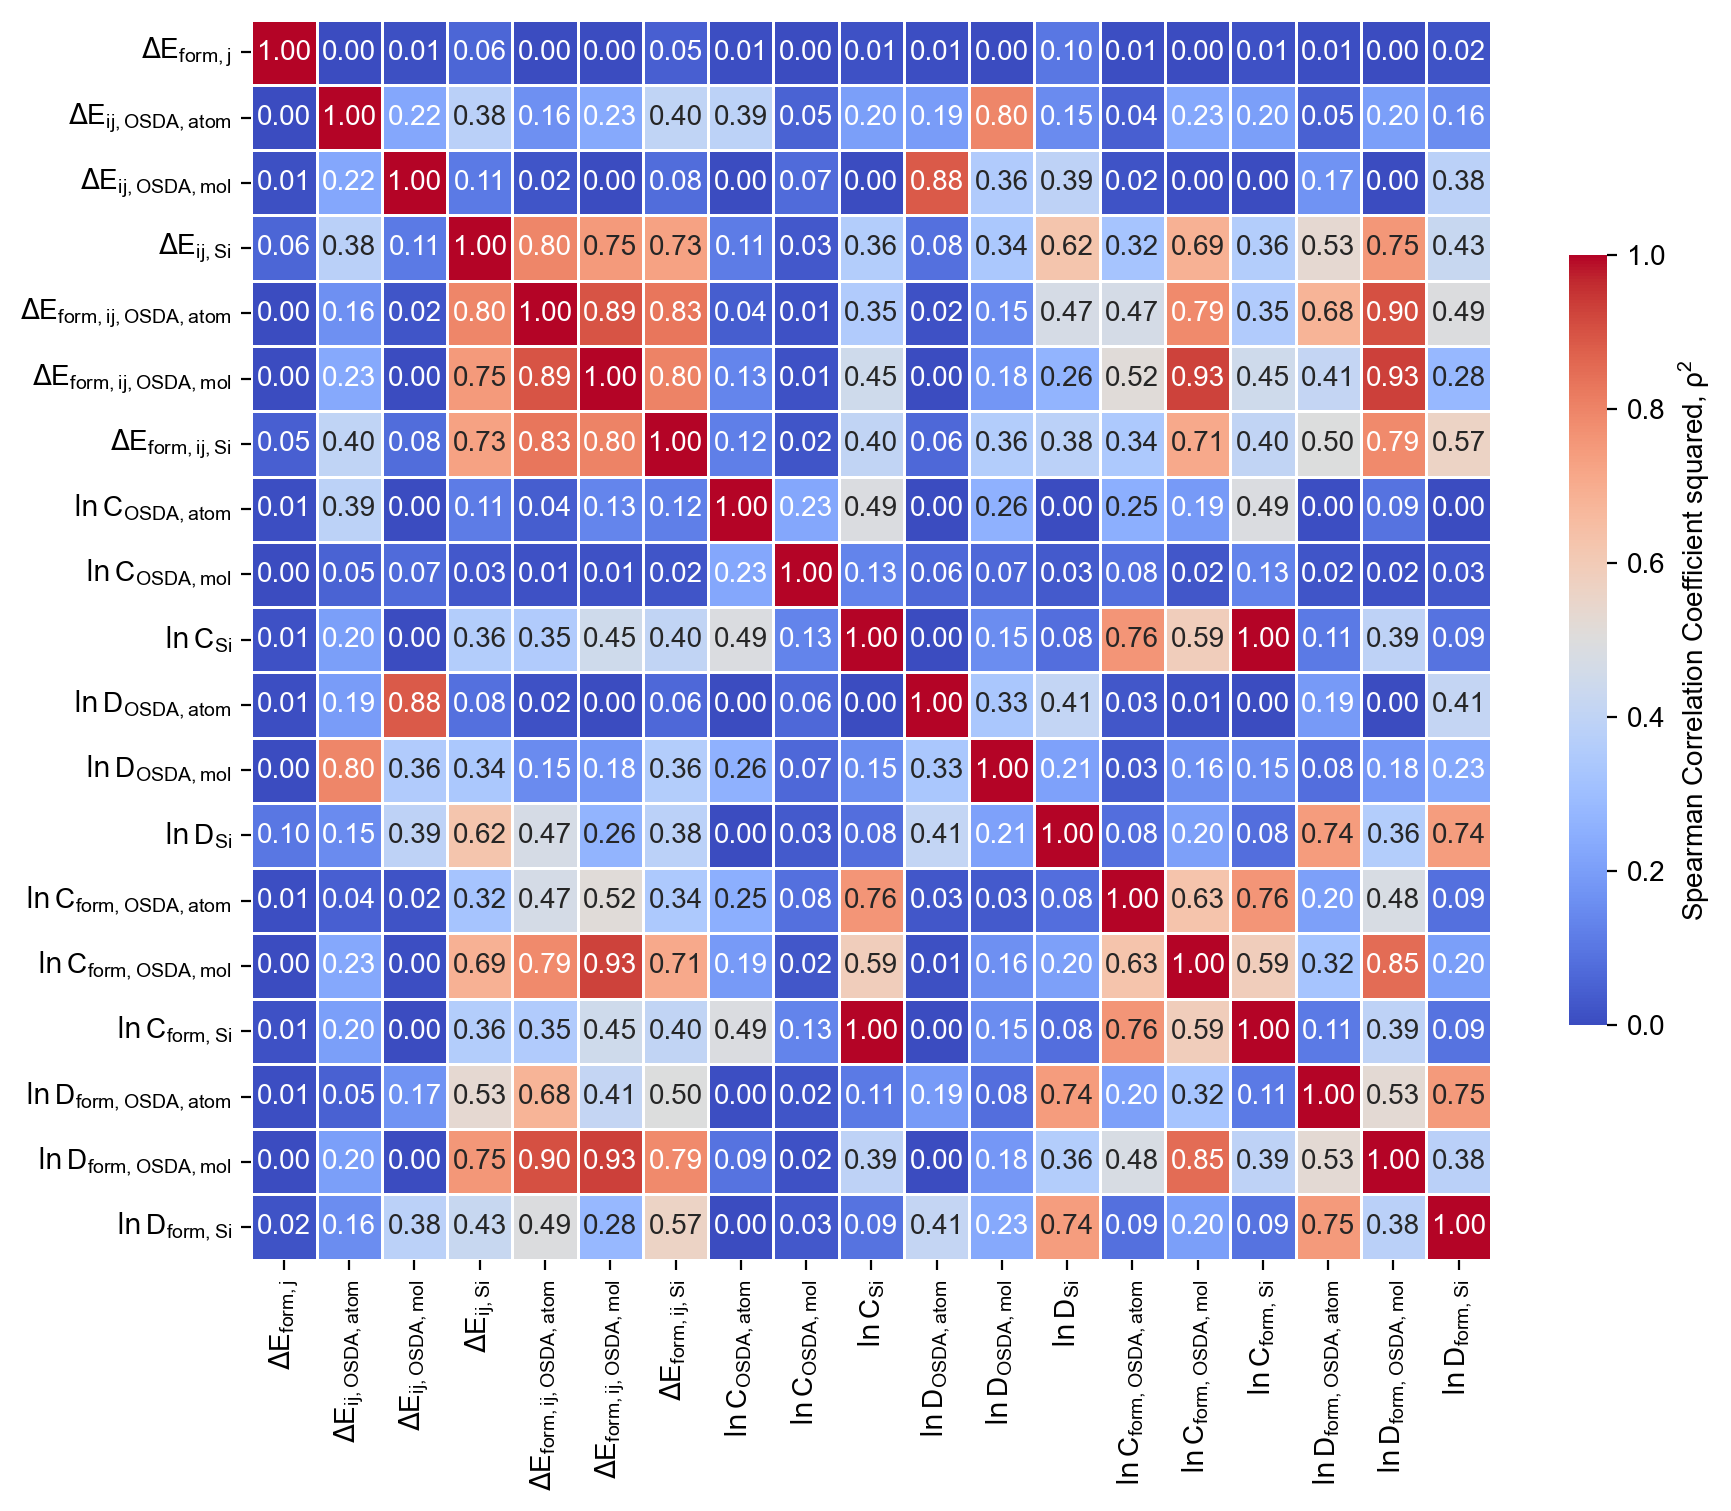

In [14]:
fig = plt.figure(figsize=(10, 10))
# annot = True to print the values inside the square
# format = '.2f' to get 2 decimal places
norm = mpl.colors.Normalize(vmin=0, vmax=1)
ax = sns.heatmap(
    heatmap_df,
    # mask=mask,
    cmap="coolwarm",
    center=0.5,
    square=True,
    linewidths=0.5,
    cbar_kws={
        "shrink": 0.5,
        "label": r"Spearman Correlation Coefficient squared, $\mathdefault{\rho}^{\mathdefault{2}}$",
        "orientation": "vertical",
        "ticks": [0, 0.2, 0.4, 0.6, 0.8, 1],
        # "norm": norm,
        # "fontweight": "bold",
    },
    annot=True,
    fmt=".2f",
)
ax.collections[0].set_clim(0, 1)
fig.savefig("images/heatmap_spearman_corr_annotated.svg", bbox_inches="tight")

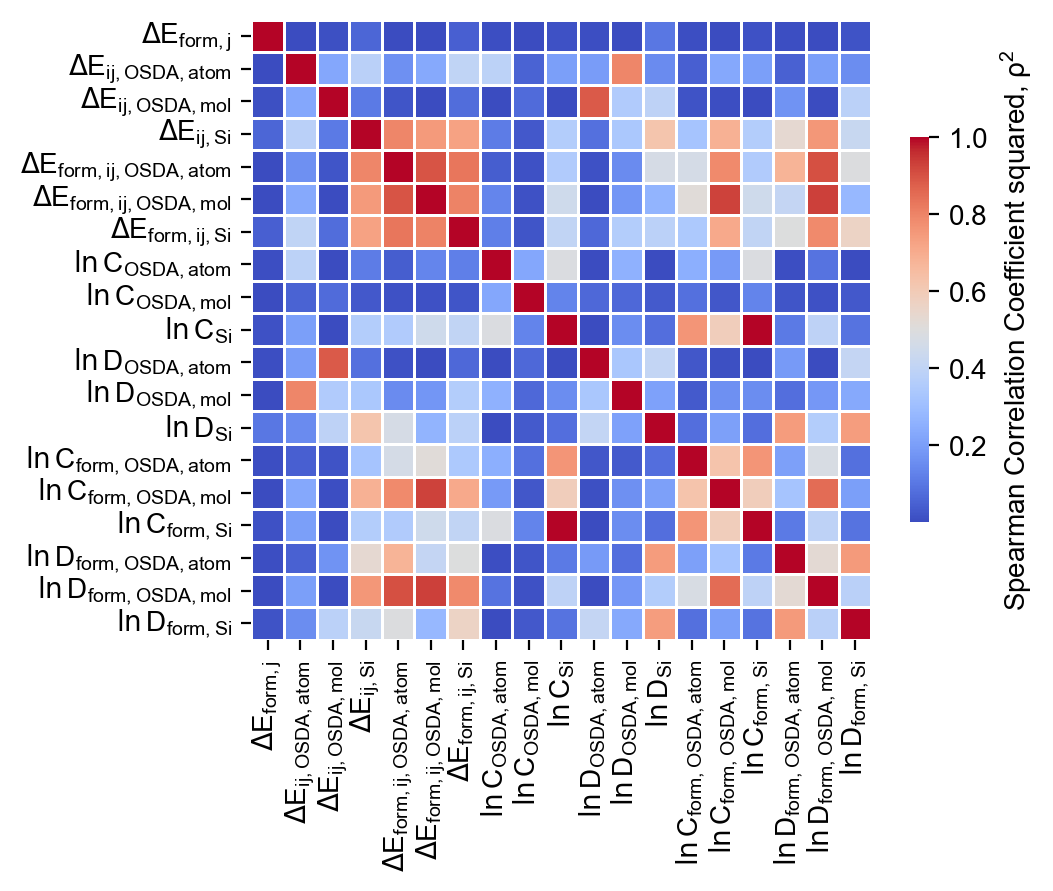

In [15]:
fig = plt.figure(figsize=(5, 5))
# annot = True to print the values inside the square
# format = '.2f' to get 2 decimal places
sns.heatmap(
    heatmap_df,
    # mask=mask,
    cmap="coolwarm",
    center=0.5,
    square=True,
    linewidths=0.5,
    cbar_kws={
        "shrink": 0.5,
        "label": r"Spearman Correlation Coefficient squared, $\mathdefault{\rho}^{\mathdefault{2}}$",
        "orientation": "vertical",
        "ticks": [0, 0.2, 0.4, 0.6, 0.8, 1],
        # "fontweight": "bold",
    },
    annot=False,
)
ax.collections[0].set_clim(0, 1)
fig.savefig("images/heatmap_spearman_corr_no_annot.svg", bbox_inches="tight")

Remove highly correlated columns that include formation energies (see Section 5.3 of the manuscript for explanation).

In [15]:
clean_e_df = clean_e_df.drop(
    columns=[
        "lC_fOm",
        "lD_fOa",
        "lD_fOm",
    ]
)

The sampling to generate the input data for the SISSO run follows, but we 

In [16]:
unsynth_df = clean_e_df[clean_e_df["syn"] == 0].sample(n=5000, random_state=42)
synth_df = clean_e_df[clean_e_df["syn"] == 1].sample(n=500, random_state=42)

sample_e_df = pd.concat([unsynth_df, synth_df])
sample_e_df.shape

(5500, 17)

In [17]:
sample_e_df.head()

,syn,E_F,dE_Oa,dE_Om,dE_S,dE_fOa,dE_fOm,dE_fS,lC_Oa,lC_Om,lC_S,lD_Oa,lD_Om,lD_S,lC_fOa,lC_fS,lD_fS
1789,0.0,11.423608,-4.823206,-159.165782,-6.631908,3.484873,115.000816,4.791701,-6.715731,-19.175292,-6.702616,-4.140015,-11.341565,-5.086752,-6.766390,-6.702616,-4.580686
35520,0.0,12.815528,-2.830706,-87.751871,-9.750208,0.889932,27.587883,3.065320,-6.623158,-41.957939,-6.729989,-4.819630,-33.222331,-4.224237,-5.876115,-6.729989,-4.207760
26782,0.0,11.165003,-3.451603,-141.515731,-8.844733,0.905471,37.124311,2.320269,-7.237294,-30.162443,-7.236390,-4.202300,-20.740209,-3.706345,-6.854405,-7.236390,-3.214683
21009,0.0,14.228484,-3.670474,-183.523680,-3.823410,9.988871,499.443555,10.405074,-7.102983,-34.827395,-8.305171,-3.829999,-25.052794,-4.670680,-8.364411,-8.305171,-5.038676
66119,0.0,11.599314,-1.456386,-58.255442,-3.640965,3.183340,127.333588,7.958349,-7.729007,-51.132757,-8.357089,-4.870934,-46.296057,-5.265494,-7.193707,-8.357089,-4.943062


In [18]:
fhand = "../data/sisso_sample_analysis.csv"
if not os.path.exists(fhand):
    print("Sample file not found. Adding it...")
    sample_e_df.to_csv(fhand, index=True)

In [19]:
sample_e_df["sample_id"] = (
    sample_e_df.index.astype(str) + "_" + sample_e_df["syn"].astype(int).astype(str)
)
sample_e_df = sample_e_df.drop(columns=["syn"])
sample_e_df = sample_e_df[["sample_id", *list(sample_e_df.columns[:-1])]]

In [20]:
fhand = "../data/sisso_sample.csv"
if not os.path.exists(fhand):
    print("Sample file not found. Adding it...")
    sample_e_df.to_csv(fhand, index=False)

# Analyze SISSO equations

In [21]:
full_df = pd.read_csv("../data/clean_all_data.csv")
print(len(full_df))
full_df.head()

74789


,crystal_id,Zeolite,SMILES,Ligand formula,Loading,dE_S,dE_Om,Templating,Volume (Angstrom3),syn,...,lC_fOa,lC_fS,lD_fOa,lD_fS,lC_Om,lD_Om,lC_AOm,lD_AOm,lC_fOm,lD_fOm
0,137337790,ACO,CCCCCN,C5H13N,2,-0.792990,-6.343916,19.428617,107.680,0.0,...,-3.763081,-5.177063,-5.462692,-7.613363,-21.215128,-40.662536,-24.096644,-51.616742,-32.810746,-36.236019
1,137353625,ACO,Cc1ccncc1,C6H7N,2,-3.000776,-24.006207,18.325914,96.232,0.0,...,-3.998696,-4.513224,-5.956683,-7.434522,-15.904415,-33.432341,-18.533953,-43.677207,-27.500033,-36.977180
2,137369986,ACO,NCCOCCO,C4H11NO2,3,-7.733204,-41.243755,15.525417,108.720,0.0,...,-2.634592,-3.090273,-4.440724,-5.831656,-10.721414,-33.119391,-14.687604,-43.094288,-10.776070,-20.026711
3,137352553,ACO,CCNCC,C4H11N,2,-2.536347,-20.290778,18.026902,91.104,0.0,...,-3.823833,-4.652868,-5.517742,-7.004148,-17.021574,-29.886585,-18.562155,-39.813323,-28.617192,-30.623784
4,139638010,ACO,CCCCN,C4H11N,3,-1.885987,-10.058597,19.195592,90.800,0.0,...,-3.294812,-4.848419,-5.252069,-7.667084,-20.098195,-38.772090,-21.736081,-45.225110,-20.152850,-27.230365


In [22]:
cols = [i for i in full_df.columns if "sisso" not in i]
print(cols)

['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S', 'dE_Om', 'Templating', 'Volume (Angstrom3)', 'syn', 'TdS_ads', 'ligand_atoms', 'dE_Oa', 'E_F', 'Si_count', 'dA_Om', 'dA_Oa', 'dA_S', 'dE_fOm', 'dE_fOa', 'dE_fS', 'dA_fS', 'E_T', 'E_fT', 'A_T', 'lC_Oa', 'lC_S', 'lD_Oa', 'lD_S', 'lC_AOa', 'lC_AS', 'lD_AOa', 'lD_AS', 'lC_fOa', 'lC_fS', 'lD_fOa', 'lD_fS', 'lC_Om', 'lD_Om', 'lC_AOm', 'lD_AOm', 'lC_fOm', 'lD_fOm']


In [23]:
small_df = pd.read_csv("../data/sisso_sample_analysis.csv", index_col=0)
print(len(small_df))
small_df.head()

5500


,syn,E_F,dE_Oa,dE_Om,dE_S,dE_fOa,dE_fOm,dE_fS,lC_Oa,lC_Om,lC_S,lD_Oa,lD_Om,lD_S,lC_fOa,lC_fS,lD_fS
1789,0.0,11.423608,-4.823206,-159.165782,-6.631908,3.484873,115.000816,4.791701,-6.715731,-19.175292,-6.702616,-4.140015,-11.341565,-5.086752,-6.766390,-6.702616,-4.580686
35520,0.0,12.815528,-2.830706,-87.751871,-9.750208,0.889932,27.587883,3.065320,-6.623158,-41.957939,-6.729989,-4.819630,-33.222331,-4.224237,-5.876115,-6.729989,-4.207760
26782,0.0,11.165003,-3.451603,-141.515731,-8.844733,0.905471,37.124311,2.320269,-7.237294,-30.162443,-7.236390,-4.202300,-20.740209,-3.706345,-6.854405,-7.236390,-3.214683
21009,0.0,14.228484,-3.670474,-183.523680,-3.823410,9.988871,499.443555,10.405074,-7.102983,-34.827395,-8.305171,-3.829999,-25.052794,-4.670680,-8.364411,-8.305171,-5.038676
66119,0.0,11.599314,-1.456386,-58.255442,-3.640965,3.183340,127.333588,7.958349,-7.729007,-51.132757,-8.357089,-4.870934,-46.296057,-5.265494,-7.193707,-8.357089,-4.943062


In [24]:
variable_names = [col for col in small_df.columns.to_list() if col != "syn" and "sisso" not in col]
len(variable_names)

16

In [25]:
variable_names

['E_F',
 'dE_Oa',
 'dE_Om',
 'dE_S',
 'dE_fOa',
 'dE_fOm',
 'dE_fS',
 'lC_Oa',
 'lC_Om',
 'lC_S',
 'lD_Oa',
 'lD_Om',
 'lD_S',
 'lC_fOa',
 'lC_fS',
 'lD_fS']

In [26]:
fhand = "../data/var_names.txt"
with open(fhand, "w") as f:
    for item in variable_names:
        f.write("%s\n" % item)

## Parse the SISSO equations

This repository should contain a CSV file where the outputs of the SISSO run are parsed and evaluated for each row. However, we include the code to create the file for reproducibility (the following code cells should not run if the output file exists).

In [27]:
with open("../data/sisso_expressions.txt") as f:
    sisso_expressions = [line.strip() for line in f]

In [28]:
fhand = "../data/sisso_sample_with_expr.csv"
if not os.path.exists(fhand):
    print("Sample file with SISSO expressions not found. Adding it...")
    for jj, eq in tqdm(enumerate(sisso_expressions)):
        colname = "sisso_" + f"{jj:05d}"
        new_sis_eqn = parse_sisso_eqn(eq, variable_names)
        try:
            small_df[colname] = eval(new_sis_eqn)
        except (TypeError, RuntimeWarning):
            print("Failed to evaluate expression: ", eq)

    # remove infinities and nans from the dataframe
    small_df = small_df.replace([np.inf, -np.inf], np.nan)
    small_df = small_df.dropna(axis=1)
    print(f"There are {len(small_df.columns)} columns in the dataframe.")

    print(f"Writing the data to {fhand}...")
    small_df.to_csv("../data/sisso_sample_with_expr.csv")

else:
    print("Reading the sample file with SISSO expressions...")
    small_df = pd.read_csv(fhand, index_col=0)
    # remove infinities and nans from the dataframe
    small_df = small_df.replace([np.inf, -np.inf], np.nan)
    small_df = small_df.dropna(axis=1)
    print(f"There are {len(small_df.columns)} columns in the dataframe.")

Reading the sample file with SISSO expressions...
There are 50017 columns in the dataframe.


In [29]:
small_df.head()

,syn,E_F,dE_Oa,dE_Om,dE_S,dE_fOa,dE_fOm,dE_fS,lC_Oa,lC_Om,...,sisso_49990,sisso_49991,sisso_49992,sisso_49993,sisso_49994,sisso_49995,sisso_49996,sisso_49997,sisso_49998,sisso_49999
1789,0.0,11.423608,-4.823206,-159.165782,-6.631908,3.484873,115.000816,4.791701,-6.715731,-19.175292,...,256.850530,-255.967548,-11.325078,-0.152593,-0.152593,0.086583,-18.212596,-0.088533,-0.088576,16.962573
35520,0.0,12.815528,-2.830706,-87.751871,-9.750208,0.889932,27.587883,3.065320,-6.623158,-41.957939,...,217.688460,-216.252078,-12.790479,-0.084617,-0.084617,0.072493,-26.549917,-0.084183,-0.084952,2.333973
26782,0.0,11.165003,-3.451603,-141.515731,-8.844733,0.905471,37.124311,2.320269,-7.237294,-30.162443,...,208.555412,-206.929874,-11.144533,-0.105651,-0.105651,0.086353,-20.493568,-0.092979,-0.093206,12.822117
21009,0.0,14.228484,-3.670474,-183.523680,-3.823410,9.988871,499.443555,10.405074,-7.102983,-34.827395,...,2679.589065,-2678.284612,-14.043081,-0.131842,-0.131842,0.070224,-39.223117,-0.070340,-0.070341,21.306733
66119,0.0,11.599314,-1.456386,-58.255442,-3.640965,3.183340,127.333588,7.958349,-7.729007,-51.132757,...,1119.979561,-1119.142833,-11.532946,-0.119981,-0.119981,0.083169,-24.153688,-0.089445,-0.089660,0.074392


## Fit decision trees

In [30]:
sissolist = [col for col in small_df.columns if "sisso" in col]
failed_sis_list = []
dectrees = {}
sis_scores = {}
y = small_df["syn"].to_numpy().reshape(-1, 1)

for sis in tqdm(sissolist):
    X = small_df[sis].to_numpy().reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    dectrees[sis] = DecisionTreeClassifier(max_depth=2, class_weight="balanced")
    try:
        dectrees[sis].fit(X_train, y_train)
        sis_scores[sis] = dectrees[sis].score(X_test, y_test)
    except ValueError:
        print("Failed to fit classifier for ", sis)
        failed_sis_list.append(sis)
        continue

  0%|          | 0/50000 [00:00<?, ?it/s]

 57%|█████▋    | 28586/50000 [09:32<07:02, 50.64it/s]

Failed to fit classifier for  sisso_28576


100%|██████████| 50000/50000 [16:41<00:00, 49.92it/s]


In [31]:
# remove equations that cannot have a decision tree fit
nsmall_df = small_df.drop(columns=failed_sis_list)

In [32]:
sissolist = [col for col in nsmall_df.columns if "sisso" in col]

In [33]:
sorted_keys = sorted(sis_scores, key=sis_scores.get, reverse=True)
for k in sorted_keys[:5]:
    print(k, sis_scores[k])

sisso_09235 0.9109090909090909
sisso_43947 0.9090909090909091
sisso_29572 0.9054545454545454
sisso_06159 0.9036363636363637
sisso_13063 0.9018181818181819


In [34]:
best_model_name = sorted_keys[0]

In [35]:
# worst performing models
sorted_keys = sorted(sis_scores, key=sis_scores.get, reverse=True)
for k in sorted_keys[-5:]:
    print(k, sis_scores[k])

sisso_14242 0.12181818181818181
sisso_33451 0.12181818181818181
sisso_13077 0.12
sisso_05300 0.11636363636363636
sisso_20561 0.10181818181818182


## Fit logistic curves

In [36]:
# fit logistic curves to all the sisso expressions using sklearn
logistic_models = {}
sis_log_scores = {}
y = nsmall_df["syn"].to_numpy().reshape(-1, 1).ravel()

for sis in tqdm(sissolist):
    X = nsmall_df[sis].to_numpy().reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    logistic_models[sis] = LogisticRegression(max_iter=1000, class_weight="balanced")
    logistic_models[sis].fit(X_train, y_train)
    sis_log_scores[sis] = logistic_models[sis].score(X_test, y_test)

  0%|          | 0/49999 [00:00<?, ?it/s]

100%|██████████| 49999/49999 [08:02<00:00, 103.54it/s]


In [37]:
sorted_log_keys = sorted(sis_log_scores, key=sis_log_scores.get, reverse=True)
for k in sorted_log_keys[:10]:
    print(k, sis_log_scores[k])

sisso_06053 0.9163636363636364
sisso_01370 0.9145454545454546
sisso_05692 0.9145454545454546
sisso_32334 0.9145454545454546
sisso_01835 0.9127272727272727
sisso_02925 0.9127272727272727
sisso_06589 0.9127272727272727
sisso_23611 0.9127272727272727
sisso_38436 0.9127272727272727
sisso_41155 0.9127272727272727


## Analyze how the logistic and decistion tree fits relate to one another

In [38]:
sisso_expr_ranks = {
    "sisso_model": [],
    "dectree_rank": [],
    "logistic_rank": [],
    "average_rank": [],
}

for sis in tqdm(sissolist):
    dectree_rank = sorted_keys.index(sis)
    logistic_rank = sorted_log_keys.index(sis)
    sisso_expr_ranks["sisso_model"].append(sis)
    sisso_expr_ranks["dectree_rank"].append(dectree_rank)
    sisso_expr_ranks["logistic_rank"].append(logistic_rank)
    sisso_expr_ranks["average_rank"].append((dectree_rank + logistic_rank) / 2)

sisso_rank_df = pd.DataFrame(sisso_expr_ranks)

  0%|          | 0/49999 [00:00<?, ?it/s]

100%|██████████| 49999/49999 [00:49<00:00, 1020.34it/s]


In [39]:
top_sisso_dectree_exprs = (
    sisso_rank_df.sort_values(by="dectree_rank").head(200)["sisso_model"].to_list()
)
top_sisso_logistic_exprs = (
    sisso_rank_df.sort_values(by="logistic_rank").head(400)["sisso_model"].to_list()
)
top_sisso_avg_exprs = (
    sisso_rank_df.sort_values(by="average_rank").head(600)["sisso_model"].to_list()
)

In [40]:
fhand = "../data/sisso_ranks.csv"
if not os.path.exists(fhand):
    print("Writing the ranks to a file...")
    sisso_rank_df.to_csv(fhand, index=False)

Writing the ranks to a file...


In [41]:
top_sisso_dectree_log_expr = copy.deepcopy(top_sisso_dectree_exprs)

print("Gathering best logistic expressions...")
jj = 0
while len(top_sisso_dectree_log_expr) < 400:
    if jj % 100 == 0:
        print(len(top_sisso_dectree_log_expr))
    if top_sisso_logistic_exprs[jj] not in top_sisso_dectree_log_expr and jj < len(
        top_sisso_logistic_exprs
    ):
        top_sisso_dectree_log_expr.append(top_sisso_logistic_exprs[jj])
    jj += 1

top_sisso_all_expr = copy.deepcopy(top_sisso_dectree_log_expr)

print("Gathering best average expressions...")
kk = 0
while len(top_sisso_all_expr) < 600:
    if kk % 100 == 0:
        print(len(top_sisso_all_expr))
    if top_sisso_avg_exprs[kk] not in top_sisso_all_expr and kk < len(top_sisso_avg_exprs):
        top_sisso_all_expr.append(top_sisso_avg_exprs[kk])
    kk += 1

Gathering best logistic expressions...
200
298
397
Gathering best average expressions...
400
478
563


In [42]:
top_sisso_all_expr[:5]

['sisso_09235', 'sisso_43947', 'sisso_29572', 'sisso_06159', 'sisso_13063']

In [43]:
len(top_sisso_all_expr)

600

In [44]:
# add the best sisso expression (alpha_T) to the top_sisso_all_expr list across multiple runs
# sometimes, the fitting of the decision tree or logistic regression does not find
# the best expression that we've identified over multiple runs, so we add it manually
best_sis = "sisso_13229"

if best_sis not in top_sisso_all_expr:
    print("Adding the alpha_T expression to the list...")
    top_sisso_all_expr.append("sisso_13229")

Adding the alpha_T expression to the list...


In [45]:
top_sisso_all_idx = [int(sis.split("_")[1]) for sis in top_sisso_all_expr]

In [46]:
fhand = "../data/top_sisso_all_idx.txt"
if not os.path.exists(fhand):
    print("Writing the top SISSO expressions to the file...")
    with open(fhand, "w") as f:
        for item in top_sisso_all_idx:
            f.write("%s\n" % item)